<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [93]:
from collections import Counter
import squarify
import matplotlib.pyplot as plt
import re
import pandas as pd

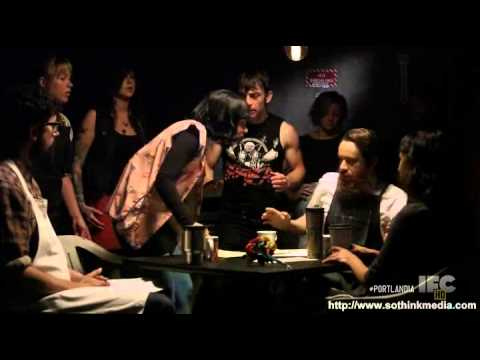

In [73]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [74]:
%pwd

'/Users/filch/Desktop/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [75]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)

## Quick visual on the data

In [76]:
# Start here 
print(shops.shape)
shops.head()

(7616, 3)


,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## Clean & organize the data

Created a quick sketch here to see how the data is distributed. Data clearly is not a random distribution.

In [77]:
sketch = pd.DataFrame([shops['coffee_shop_name'].value_counts()], [shops['star_rating'].value_counts()])

In [78]:
sketch.T.head(20)

star_rating,3780,2360,738,460,278
Epoch Coffee,400,400,400,400,400
Halcyon,300,300,300,300,300
The Factory - Cafe With a Soul,244,244,244,244,244
Venezia Italian Gelato,200,200,200,200,200
Houndstooth Coffee,200,200,200,200,200
Caffé Medici,143,143,143,143,143
Apanas Coffee & Beer,136,136,136,136,136
Pacha,100,100,100,100,100
Seventh Flag Coffee Co,100,100,100,100,100
Juan Pelota,100,100,100,100,100


Separate the date from the review. Take out the check-in notification. Remove excess signaling in rating, forced float.

In [79]:
shops['rating'] = shops['star_rating'].apply(lambda x: x[:4]).astype('float')

In [80]:
shops['date'] = shops['full_review_text'].apply(lambda x: x.split()[0])

In [81]:
shops['review'] = shops['full_review_text'].apply(lambda x: " ".join(x.split()[1:]))

In [82]:
shops['review'] = shops['review'].apply(lambda x: x.replace("1 check-in", ""))

In [83]:
shops = shops.drop(['star_rating', 'full_review_text'], axis=1)

Data is nice and clean and organized

In [84]:
shops.head()

,coffee_shop_name,rating,date,review
0,The Factory - Cafe With a Soul,5.0,11/25/2016,Love love loved the atmosphere! Every corner ...
1,The Factory - Cafe With a Soul,4.0,12/2/2016,"Listed in Date Night: Austin, Ambiance in Aust..."
2,The Factory - Cafe With a Soul,4.0,11/30/2016,Listed in Brunch Spots I loved the eclectic a...
3,The Factory - Cafe With a Soul,2.0,11/25/2016,Very cool decor! Good drinks Nice seating Howe...
4,The Factory - Cafe With a Soul,4.0,12/3/2016,They are located within the Northcross mall s...


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [121]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [135]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    lemmas = lemmas
    return lemmas

In [136]:
shops['lemmas'] = shops['review'].apply(get_lemmas)

In [137]:
shops['lemmas'].head()

0    [ , Love, love, love, atmosphere, corner, coff...
1    [list, Date, Night, Austin, Ambiance, Austin, ...
2    [ , list, Brunch, Spots, love, eclectic, homey...
3    [cool, decor, good, drink, nice, seating, over...
4    [ , locate, Northcross, mall, shopping, center...
Name: lemmas, dtype: object

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [138]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

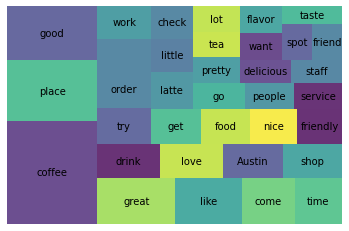

In [139]:
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 35]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [151]:
tokens = shops[['lemmas']]['lemmas']\
                        .apply(pd.Series)\
                        .reset_index()\
                        .melt(id_vars="index")\
                        .dropna()[['index', 'value']]\
                        .sort_values('index')\
                        .set_index('index')

In [152]:
print(tokens.shape)
tokens.head(50)

(359697, 1)


,value
index,
0,
0,hope
0,wine
0,minute
0,get
0,atmosphere
0,latte
0,love
0,get


In [153]:
tokens = tokens.join(shops[['rating']], how='inner')

In [154]:
tokens.shape


(359697, 2)

In [155]:
tokens.head()

,value,rating
0,,5.0
0,hope,5.0
0,wine,5.0
0,minute,5.0
0,get,5.0


In [156]:
word_rating = tokens.groupby('value').mean()
word_count = tokens.groupby('value').count()

words = word_rating.join(word_count, lsuffix='_mean', rsuffix='_count')
words = words.sort_values(by=['rating_count', 'rating_mean'], ascending=False)

In [158]:
word_rating.head(50)

,rating
value,
,4.149744
"""Wait",4.000000
"""a",4.000000
"""why",5.000000
#2?,5.000000
$,3.561028
(=,4.000000
(create,3.000000
(just,1.000000


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

